In [1]:
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

%matplotlib inline

In [2]:
os.chdir('/Users/Daniel1020/Downloads')

In [3]:
def parse_json(data):
    session_id=[]
    timestamp=[]
    cities=[]
    user_id=[]
    joining_date=[]
    country=[]
    
    for item in data:
        session_id.append(item['session_id'][0])
        timestamp.append(item['unix_timestamp'][0])
        cities.append(item['cities'][0])
        user_id.append(item['user'][0][0]['user_id'])
        joining_date.append(item['user'][0][0]['joining_date'])
        country.append(item['user'][0][0]['country'])
        
        #create dataframe
    maps = {'session_id':session_id,
           'timestamp':timestamp,
           'cities':cities,
           'user_id':user_id,
           'joining_date':joining_date,
           'country':country}
    columns=['session_id','timestamp','cities','user_id','joining_date','country']
    
    return pd.DataFrame(maps,columns=columns)

In [5]:
with open('city_search.json','r') as json_file:
    json_data=json.load(json_file)
    
data = parse_json(json_data)


In [7]:
data['timestamp']=pd.to_datetime(data['timestamp'],unit='s')
data['joining_date']=pd.to_datetime(data['joining_date'])

In [49]:
data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,X061RFWB06K9V,2015-09-17 15:28:28,"New York NY, Newark NJ",2024,2015-03-22,UK
1,5AZ2X2A9BHH5U,2015-09-04 08:06:31,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE
2,SHTB4IYAX4PX6,2015-08-29 10:18:10,San Antonio TX,10958,2015-03-06,UK
3,JBRB8MZGTX3M4,2015-03-25 07:21:03,Edmonton AB,7693,2015-03-12,IT
4,YJCMPURC2FL9C,2015-05-02 09:31:07,"Phoenix AZ, Houston TX",7506,2015-02-28,UK


In [8]:
len(data)

20022

# Question 1 
## Predit Country

In [41]:
data['country'].value_counts()

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

#### For the question1 to identify the countries missed in the table, I would dive into it based on the user search behavior. Given by the searching information here, we can only explor it with the searching timestamp.

In [10]:
data['hour']= data['timestamp'].apply(lambda x: x.hour)

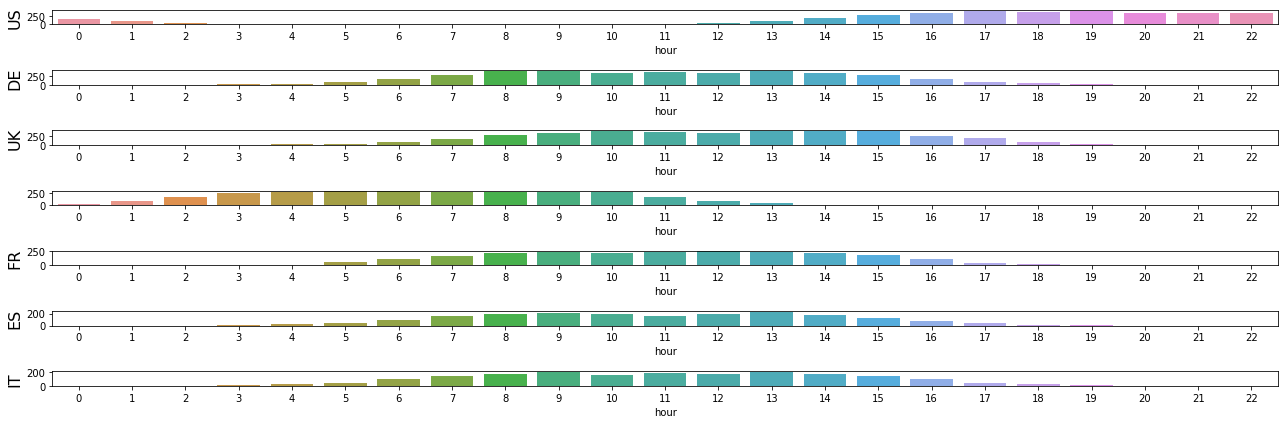

In [11]:
# visualization

countries =['US','DE','UK','','FR','ES','IT']
order= list(range(0,23))

fig,ax=plt.subplots(figsize=(18,6),ncols=1,nrows=7)
for i in range(len(countries)):
    sns.countplot(x='hour',data=data[data['country']==countries[i]],ax=ax[i],order=order)
    ax[i].set_ylabel(countries[i],fontsize=16)
plt.tight_layout()
plt.show()


# Question 2

In [12]:
city_pair=data['cities'].apply(lambda x: x.split(', '))
index = 0
maps = {}
city_list = []

for item in city_pair:
    for city in item:
        if city not in maps:
            maps[city]=index
            index +=1
            city_list.append(city)
            
print ('Unique cities:\t',len(city_list))


Unique cities:	 89


In [15]:
pair_matrix = np.zeros((89,89))

for item in city_pair:
    if len(item)==1:
        continue
    for i in range(len(item)-1):
        index1=maps[item[i]]
        for j in range(i+1,len(item)):
            index2 = maps[item[j]]
            pair_matrix[index1,index2] +=1
            pair_matrix[index2,index1] +=1

In [16]:
smilarity = pd.DataFrame(pair_matrix,index=city_list,columns=city_list)
smilarity.head()

,New York NY,Newark NJ,Jersey City NJ,Philadelphia PA,San Antonio TX,Edmonton AB,Phoenix AZ,Houston TX,San Diego CA,Montreal QC,...,Birmingham AL,Nashville TN,Omaha NE,Kansas City MO,Raleigh NC,Greensboro NC,New Orleans LA,Charlotte NC,Lincoln NE,Memphis TN
New York NY,0.0,435.0,549.0,428.0,58.0,39.0,63.0,193.0,60.0,315.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Newark NJ,435.0,0.0,249.0,230.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
Jersey City NJ,549.0,249.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Philadelphia PA,428.0,230.0,201.0,0.0,0.0,0.0,0.0,13.0,0.0,33.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
San Antonio TX,58.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.0,21.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


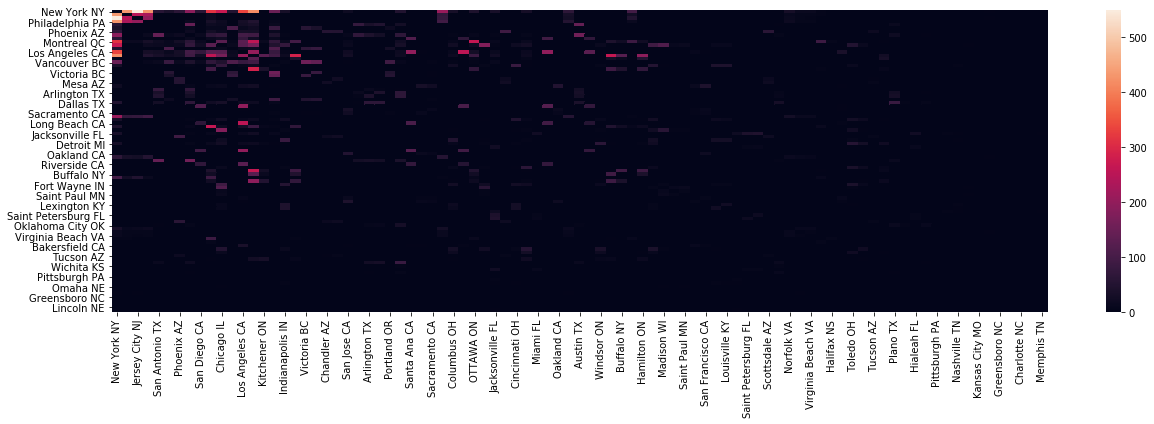

In [17]:
fig,ax=plt.subplots(figsize=(18,6))
sns.heatmap(smilarity,ax=ax)

plt.tight_layout()
plt.show()


In [18]:
results=smilarity.apply(np.argmax,axis=0).reset_index()
results=results.rename(columns={'index':'city',0:'most_relatable'})

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [64]:
results.head()

,city,most_relatable
0,New York NY,Jersey City NJ
1,Newark NJ,New York NY
2,Jersey City NJ,New York NY
3,Philadelphia PA,New York NY
4,San Antonio TX,Houston TX


# Question 3

In [21]:
smilarity.head()

,New York NY,Newark NJ,Jersey City NJ,Philadelphia PA,San Antonio TX,Edmonton AB,Phoenix AZ,Houston TX,San Diego CA,Montreal QC,...,Birmingham AL,Nashville TN,Omaha NE,Kansas City MO,Raleigh NC,Greensboro NC,New Orleans LA,Charlotte NC,Lincoln NE,Memphis TN
New York NY,0.0,435.0,549.0,428.0,58.0,39.0,63.0,193.0,60.0,315.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Newark NJ,435.0,0.0,249.0,230.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
Jersey City NJ,549.0,249.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Philadelphia PA,428.0,230.0,201.0,0.0,0.0,0.0,0.0,13.0,0.0,33.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
San Antonio TX,58.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.0,21.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
def search_distance(cities):
    cities = cities.split(", ")
    if len(cities)==1:
        return 0
    
    distance=0
    for i in range(len(cities)-1):
        city1=cities[i]
        for j in range(i+1,len(cities)):
            city2=cities[j]
            distance +=smilarity.loc[city1, city2]
    return distance/len(cities)

data['distance']=data['cities'].apply(search_distance)
            

In [27]:
data.head()

,session_id,timestamp,cities,user_id,joining_date,country,hour,distance
0,X061RFWB06K9V,2015-09-17 15:28:28,"New York NY, Newark NJ",2024,2015-03-22,UK,15,217.500000
1,5AZ2X2A9BHH5U,2015-09-04 08:06:31,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE,8,392.666667
2,SHTB4IYAX4PX6,2015-08-29 10:18:10,San Antonio TX,10958,2015-03-06,UK,10,0.000000
3,JBRB8MZGTX3M4,2015-03-25 07:21:03,Edmonton AB,7693,2015-03-12,IT,7,0.000000
4,YJCMPURC2FL9C,2015-05-02 09:31:07,"Phoenix AZ, Houston TX",7506,2015-02-28,UK,9,9.000000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


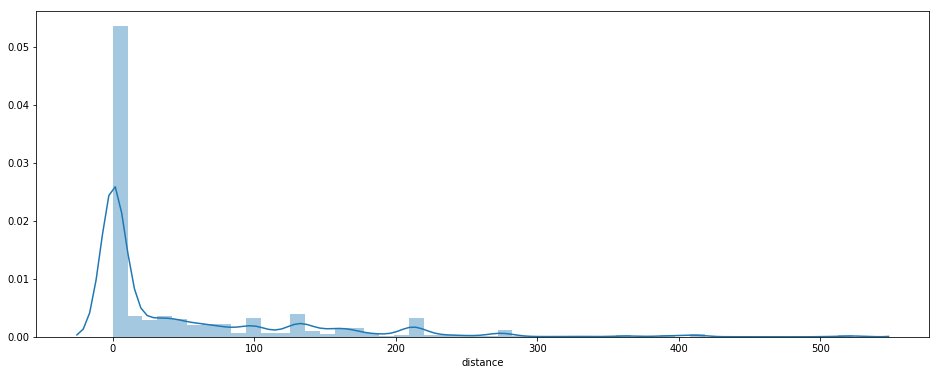

In [29]:
fig,ax= plt.subplots(figsize=(16,6))

sns.distplot(data['distance'],ax=ax,bins=50)
plt.show()